In [1]:
import pandas as pd
import pickle
from sportsreference.ncaab.teams import Teams
from sportsreference.ncaab.conferences import Conferences
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rnd
from utils import  score_table
import importlib

#import argparse

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.optim import ClippedAdam
from torch.distributions import constraints

In [78]:
majorConfs = ["big-12","Big 12",
              "big-10","Big Ten","big-ten",
              "sec","SEC",
              "big-east","Big East",
              "pac-12","Pac-12",
              "acc","ACC",
              "wcc", "WCC",
              "atlantic-10","Atlantic 10"]
confNameNorm = {"Big 12":"big-12",
              "Big Ten":"big-ten",
              "big-ten":"big-ten",
              "SEC":"sec",
              "Big East":"big-east",
              "Pac-12":"pac-12",
              "ACC":"acc",
              "WCC":"wcc",
               "Atlantic 10":"atlantic-10"}
def getDataForTeams(teams) :
    dataset = pd.DataFrame()
    for team in teams:
        if team.conference in majorConfs:
            tgDF = team.schedule.dataframe
            tgDF['team_name'] = team.name
            tgDF['team_conference'] = team.conference
            dataset = pd.concat([dataset,tgDF])     
    return dataset


In [3]:
#execute this cell to grab the data from the site
season_team_list = Teams("2022")
df = getDataForTeams(season_team_list)
compression_opts = dict(method='zip',
                        archive_name='outv3.csv')  
df.to_csv('data/bigconfs2022Season.zip', compression=compression_opts) 
pickle.dump( season_team_list, open( "data/teams2022.p", "wb" ) )

In [197]:
#execute this cell to just load the local files
season_team_list = pickle.load( open( "data/teams2022.p", "rb" ) )
c_opts = dict(method='zip')
df = pd.read_csv('data/bigconfs2022Season.zip',compression='zip')

In [124]:
df.columns

Index(['Unnamed: 0', 'arena', 'boxscore_index', 'date', 'datetime', 'game',
       'location', 'opponent_abbr', 'opponent_conference', 'opponent_name',
       'opponent_rank', 'overtimes', 'points_against', 'points_for', 'result',
       'season_losses', 'season_wins', 'streak', 'time', 'type', 'team_name',
       'team_conference'],
      dtype='object')

In [171]:
df.location.unique()

array(['Home', 'Neutral', 'Away'], dtype=object)

In [125]:

def replicateSwappingHomeAndAway(df):
    cdf = df.copy()
    swapdf = pd.DataFrame(columns=['Date','HomeTeam','AwayTeam','FTHG','FTAG'])

    swapdf['Date'] = df.Date
    swapdf['HomeTeam'] = df.AwayTeam
    swapdf['AwayTeam'] = df.HomeTeam
    swapdf['FTHG'] = df.FTAG
    swapdf['FTAG'] = df.FTHG
    
    fdf = pd.concat([cdf,swapdf], axis=0)
    fdf.reset_index(inplace=True, drop=True)
    return fdf

foo = pd.DataFrame({'Date':['monday','tuesday'],
                    'HomeTeam':['msu','uw'],
                    'AwayTeam':['um','purdue'],
                    'FTHG':[99,88],
                    'FTAG':[25,75]})
foobar = replicateSwappingHomeAndAway(foo)
foobar

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,monday,msu,um,99,25
1,tuesday,uw,purdue,88,75
2,monday,um,msu,25,99
3,tuesday,purdue,uw,75,88


In [179]:
#for neutral
#bdf["location"] == 'Neutral'

selector_neut = {'date':'Date', 'team_name':'HomeTeam', 'opponent_name':'AwayTeam',
              'points_for':'FTHG', 'points_against':'FTAG'}

test = ndf.rename(columns=selector_neut)[selector_neut.values()]
test.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
31,"Thu, Mar 10, 2022",Alabama,Vanderbilt,76.0,82.0
36,"Wed, Nov 24, 2021",Arizona State,Baylor,63.0,75.0
62,"Wed, Mar 9, 2022",Arizona State,Stanford,70.0,71.0
67,"Sun, Nov 21, 2021",Arizona,Michigan,80.0,62.0
94,"Thu, Mar 10, 2022",Arizona,Stanford,84.0,80.0
...,...,...,...,...,...
3189,"Thu, Mar 10, 2022",West Virginia,Kansas,63.0,87.0
3193,"Mon, Nov 22, 2021",Wisconsin,Texas A&M,69.0,58.0
3220,"Fri, Mar 11, 2022",Wisconsin,Michigan State,63.0,69.0
3226,"Wed, Nov 24, 2021",Xavier,Iowa State,70.0,82.0


In [201]:
#keepConfs = majorConfs
keepConfs = ["big-10","Big Ten","big-ten",
            "big-12","Big 12",
            "sec","SEC",
              "big-east","Big East",
              "pac-12","Pac-12"]


bdf = df
#only have games between big conferences
bdf = bdf[(bdf["opponent_conference"].isin(keepConfs)) & 
         (bdf["team_conference"].isin(keepConfs)) ]

#get rid of duplicates
bdf.drop_duplicates(subset='boxscore_index', keep="first")
#drop Neutral games for now
ndf = bdf[bdf["location"] == 'Neutral']
bdf = bdf[bdf["location"].isin(["Home","Away"])]

#create Home, Away, neutral indicator columns
bdf = pd.get_dummies(bdf,prefix=['location'], columns = ['location'])
#create homeTeam, awayTeam columns
def addHomeTeamColumn(row):
    if(row['location_Home'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['HomeTeam'] = bdf.apply(addHomeTeamColumn, axis=1)
def addAwayTeamColumn(row):
    if(row['location_Away'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['AwayTeam'] = bdf.apply(addAwayTeamColumn, axis=1)
#add in "HomePoints" , AwayPoints
def addHomePointsColumn(row):
    if(row['location_Home'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['HomePoints'] = bdf.apply(addHomePointsColumn, axis=1)
def addAwayPointsColumn(row):
    if(row['location_Away'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['AwayPoints'] = bdf.apply(addAwayPointsColumn, axis=1)

#neutral games; double them with swapped home and away
selector_neut = {'date':'Date', 'team_name':'HomeTeam', 'opponent_name':'AwayTeam',
              'points_for':'FTHG', 'points_against':'FTAG'}
ndf = ndf.rename(columns=selector_neut)[selector_neut.values()]
ndf.reset_index(inplace=True,drop=True)
ndfd = replicateSwappingHomeAndAway(ndf)



#just big ten conference games
big10df = bdf.loc[(bdf["team_conference"]=='big-ten')&
                  (bdf['opponent_conference']=='Big Ten')]

#rename columns
selector_d = {'date':'Date', 'HomeTeam':'HomeTeam', 'AwayTeam':'AwayTeam',
              'HomePoints':'FTHG', 'AwayPoints':'FTAG'}
bdf = bdf.rename(columns=selector_d)[selector_d.values()]
bdf.reset_index(inplace=True, drop=True)
big10df = big10df.rename(columns=selector_d)[selector_d.values()]
big10df.reset_index(inplace=True, drop=True)

bdfd = replicateSwappingHomeAndAway(bdf)
big10dfd = replicateSwappingHomeAndAway(big10df)
bdfplusN = pd.concat([bdf,ndfd],axis=0)
bdfplusN.reset_index(inplace=True, drop=True)

bdf.head()




,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,"Wed, Dec 29, 2021",Alabama,Tennessee,73.0,68.0
1,"Wed, Jan 5, 2022",Florida,Alabama,70.0,83.0
2,"Sat, Jan 8, 2022",Missouri,Alabama,92.0,86.0
3,"Tue, Jan 11, 2022",Alabama,Auburn,77.0,81.0
4,"Sat, Jan 15, 2022",Mississippi State,Alabama,78.0,76.0


In [187]:
bdfplusN.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
1607,"Thu, Mar 10, 2022",Kansas,West Virginia,87.0,63.0
1608,"Mon, Nov 22, 2021",Texas A&M,Wisconsin,58.0,69.0
1609,"Fri, Mar 11, 2022",Michigan State,Wisconsin,69.0,63.0
1610,"Wed, Nov 24, 2021",Iowa State,Xavier,82.0,70.0
1611,"Wed, Mar 9, 2022",Butler,Xavier,89.0,82.0


In [194]:
ndfd[ndfd['Date']=='Mon, Nov 22, 2021']

,Date,HomeTeam,AwayTeam,FTHG,FTAG
7,"Mon, Nov 22, 2021",Arkansas,Kansas State,72.0,64.0
21,"Mon, Nov 22, 2021",California,Florida,60.0,80.0
34,"Mon, Nov 22, 2021",Florida,California,80.0,60.0
54,"Mon, Nov 22, 2021",Kansas State,Arkansas,64.0,72.0
90,"Mon, Nov 22, 2021",Northwestern,Providence,72.0,77.0
94,"Mon, Nov 22, 2021",Ohio State,Seton Hall,79.0,76.0
109,"Mon, Nov 22, 2021",Providence,Northwestern,77.0,72.0
118,"Mon, Nov 22, 2021",Seton Hall,Ohio State,76.0,79.0
136,"Mon, Nov 22, 2021",Texas A&M,Wisconsin,58.0,69.0
174,"Mon, Nov 22, 2021",Wisconsin,Texas A&M,69.0,58.0


In [175]:
len(bdf.index)

1256

In [178]:
[len(ndf.index),ndf.date.min()]

[178, 'Fri, Mar 11, 2022']

In [117]:
[len(bdf.index),len(bdfd.index)]

[1798, 3596]

In [6]:
bdf.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'], dtype='object')

In [132]:
[len(bdfd.HomeTeam.unique()),len(bdfd.AwayTeam.unique())]

[24, 24]

In [33]:
[len(big10df.HomeTeam.unique()),len(big10df.AwayTeam.unique())]

[14, 14]

In [24]:
len(list(set(bdf.HomeTeam.unique().tolist()).union(set(bdf.AwayTeam.unique().tolist()))))

98

In [85]:
def transformData(data):
    pl_data = data

    ng = len(pl_data)  # number of games
    npr = 45  # predict the last 5 rounds of games
    ngob = ng - npr  # number of games to train

    pl_data = pl_data.rename(columns={"FTHG": "score1","FTAG":"score2",
                            "HomeTeam":"Home","AwayTeam":"Away"})

    #teams = pl_data["Home"].unique()
    teams = list(set(pl_data.Home.unique().tolist()).union(set(pl_data.Away.unique().tolist())))
    teams = pd.DataFrame(teams, columns=["Team"])
    teams["i"] = teams.index

    df = pd.merge(pl_data, teams, left_on="Home", right_on="Team", how="left")
    df = df.rename(columns={"i": "Home_id"}).drop("Team", axis=1)
    df = pd.merge(df, teams, left_on="Away", right_on="Team", how="left")
    df = df.rename(columns={"i": "Away_id"}).drop("Team", axis=1)

    print(df.head())

    return teams, df


In [202]:
tt,dd = transformData(bdfplusN)

                Date               Home       Away  score1  score2  Home_id  \
0  Wed, Dec 29, 2021            Alabama  Tennessee    73.0    68.0       41   
1   Wed, Jan 5, 2022            Florida    Alabama    70.0    83.0       43   
2   Sat, Jan 8, 2022           Missouri    Alabama    92.0    86.0       35   
3  Tue, Jan 11, 2022            Alabama     Auburn    77.0    81.0       41   
4  Sat, Jan 15, 2022  Mississippi State    Alabama    78.0    76.0        0   

   Away_id  
0       18  
1       41  
2       41  
3        2  
4       41  


In [149]:
tt

,Team,i
0,Virginia,0
1,Mississippi State,1
2,Colorado,2
3,Marquette,3
4,Auburn,4
...,...,...
71,Nebraska,71
72,Utah,72
73,Kansas,73
74,Wake Forest,74


In [95]:
dd.score1.describe()

count    560.000000
mean      70.792857
std       10.745051
min       45.000000
25%       64.000000
50%       70.000000
75%       78.000000
max      110.000000
Name: score1, dtype: float64

In [96]:
h_id = torch.tensor(dd["Home_id"])
a_id = torch.tensor(dd["Away_id"])


[len(list(set(h_id.unique().tolist()).union(set(a_id.unique().tolist())))),len(h_id),len(a_id)
,len(h_id.unique()),len(a_id.unique()) ]

[14, 560, 560, 14, 14]

In [97]:
class FoldedTransform(dist.transforms.AbsTransform):
    def log_abs_det_jacobian(self, x, y):
        return torch.zeros_like(x)

def model(home_id, away_id, score1_obs=None, score2_obs=None):
    # hyperpriors
    alpha = pyro.sample("alpha", dist.Normal(0.0, 1.0))
    sd_att = pyro.sample("sd_att", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 4), FoldedTransform()))
    sd_def = pyro.sample("sd_def", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 4), FoldedTransform()))
    #student t: degrees of freedom, mean, width
    #started with width = 2.5
    home = pyro.sample("home", dist.Normal(0.0, 2.0))  # home advantage
    #started with 1.0 for std

    #this has to be the number of teams!!! 
    #nt = len(np.unique(home_id))
    nt = len(list(set(np.unique(home_id).tolist()).union(set(np.unique(away_id).tolist()))))


    # team-specific model parameters
    with pyro.plate("plate_teams", nt):
        attack = pyro.sample("attack", dist.Normal(0, sd_att))
        defend = pyro.sample("defend", dist.Normal(0, sd_def))

    # likelihood
    theta1 = torch.exp(alpha + home + attack[home_id] - defend[away_id])
    theta2 = torch.exp(alpha + attack[away_id] - defend[home_id])

    with pyro.plate("data", len(home_id)):
        pyro.sample("s1", dist.Poisson(theta1), obs=score1_obs)
        pyro.sample("s2", dist.Poisson(theta2), obs=score2_obs)

def guide(home_id, away_id, score1_obs=None, score2_obs=None):
    mu_locs = pyro.param("mu_loc", torch.tensor(0.0).expand(4))
    mu_scales = pyro.param("mu_scale", torch.tensor(0.1).expand(4), constraint=constraints.positive)

    pyro.sample("alpha", dist.Normal(mu_locs[0], mu_scales[0]))
    pyro.sample("sd_att", dist.LogNormal(mu_locs[1], mu_scales[1]))
    pyro.sample("sd_def", dist.LogNormal(mu_locs[2], mu_scales[2]))
    pyro.sample("home", dist.Normal(mu_locs[3], mu_scales[3]))  # home advantage

    nt = len(list(set(np.unique(home_id).tolist()).union(set(np.unique(away_id).tolist()))))
    #nt = len(np.unique(home_id))
    #print("number of teams: ", nt)

    mu_team_locs = pyro.param("mu_team_loc", torch.tensor(0.0).expand(2, nt))
    mu_team_scales = pyro.param("mu_team_scale", torch.tensor(0.1).expand(2, nt), constraint=constraints.positive)

    with pyro.plate("plate_teams", nt):
        pyro.sample("attack", dist.Normal(mu_team_locs[0], mu_team_scales[0]))
        pyro.sample("defend", dist.Normal(mu_team_locs[1], mu_team_scales[1]))

def run_inference(model, guide, home_id, away_id, score1, score2, args):
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / args.num_iterations)

    svi = SVI(
        model=model,
        guide=guide,
        optim=ClippedAdam({"lr": args.learning_rate, "lrd": lrd}),
        loss=Trace_ELBO(num_particles=args.num_particles),
    )

    pyro.clear_param_store()  # clear global parameter cache
    pyro.set_rng_seed(args.rng_seed)

    advi_loss = []
    for j in range(args.num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(
            home_id=home_id,
            away_id=away_id,
            score1_obs=score1.float(),
            score2_obs=score2.float(),
        )
        advi_loss.append(loss)
        if j % 100 == 0:
            print("[iteration %4d] loss: %.4f" % (j + 1, loss))

    print("Posterior: ")
    for i in pyro.get_param_store().items():
        print(i)

    fit = Predictive(model=model, guide=guide, num_samples=2000)(
        home_id=home_id, away_id=away_id
    )

    return fit

def runThePyroFit(data,args):
    print("transforming data...")
    teams, df =  transformData(data)
    #train = df[df["split"] == "train"]
    train = df

    print("Starting inference...")
    fit = run_inference(
        model,
        guide,
        torch.tensor(train["Home_id"]),
        torch.tensor(train["Away_id"]),
        torch.tensor(train["score1"]),
        torch.tensor(train["score2"]),
        args,
    )
    return fit,teams,df,train

#def runThePyroCodeRest(data,args,fit):
def runThePyroCodeRest(fit,teams,df,train):
#    print("transforming data...")
#    teams, df =  transformData(data)
#    train = df[df["split"] == "train"]

#    print("Starting inference...")
#    fit = run_inference(
#        model,
#        guide,
#        torch.tensor(train["Home_id"]),
#        torch.tensor(train["Away_id"]),
#        torch.tensor(train["score1"]),
#        torch.tensor(train["score2"]),
#        args,
#    )

    print("Analyse posterior...")


    # Predicted goals and table
    #predict = df[df["split"] == "predict"]
    predict = predictDF
    #print("this many home_ids: " , predict.Home_id.unique())

    predictive = Predictive(
        model=model, guide=guide, num_samples=2000, return_sites=["s1", "s2"]
    )
 
    predicted_score = predictive(
        home_id=predict["Home_id"].values,
        away_id=predict["Away_id"].values,
    )

    predicted_full = predict.copy()
    predicted_full = predicted_full.assign(
        score1=predicted_score["s1"].mean(axis=0).round(),
        score1error=predicted_score["s1"].std(axis=0),
        score2=predicted_score["s2"].mean(axis=0).round(),
        score2error=predicted_score["s2"].std(axis=0),
    )

    predicted_full = train.append(
        predicted_full.drop(columns=["score1error", "score2error"])
    )

    print(score_table(df))
    print(score_table(predicted_full))

def qualityCalc(fit,teams,df,train):
    # Attack and defence
    quality = teams.copy()

    quality = quality.assign(
        attack=fit["attack"].mean(axis=0),
        attacksd=fit["attack"].std(axis=0),
        defend=fit["defend"].mean(axis=0),
        defendsd=fit["defend"].std(axis=0),
    )
    quality = quality.assign(
        attack_low=quality["attack"] - quality["attacksd"],
        attack_high=quality["attack"] + quality["attacksd"],
        defend_low=quality["defend"] - quality["defendsd"],
        defend_high=quality["defend"] + quality["defendsd"],
    )
    #gotta debug this
    return quality




In [203]:
class Args():
    learning_rate = 0.1
    num_particles = 1
    rng_seed = 1
    num_iterations = 2000

args=Args()
fit,teams,df,train = runThePyroFit(bdfplusN,args)

transforming data...
                Date               Home       Away  score1  score2  Home_id  \
0  Wed, Dec 29, 2021            Alabama  Tennessee    73.0    68.0       41   
1   Wed, Jan 5, 2022            Florida    Alabama    70.0    83.0       43   
2   Sat, Jan 8, 2022           Missouri    Alabama    92.0    86.0       35   
3  Tue, Jan 11, 2022            Alabama     Auburn    77.0    81.0       41   
4  Sat, Jan 15, 2022  Mississippi State    Alabama    78.0    76.0        0   

   Away_id  
0       18  
1       41  
2       41  
3        2  
4       41  
Starting inference...


ValueError: Error while computing log_prob at site 's1':
Expected value argument (Tensor of shape (1278,)) to be within the support (IntegerGreaterThan(lower_bound=0)) of the distribution Poisson(rate: torch.Size([1278])), but found invalid values:
tensor([73., 70., 92.,  ..., 69., 82., 89.])
Trace Shapes:       
 Param Sites:       
Sample Sites:       
   alpha dist      |
        value      |
     log_prob      |
  sd_att dist      |
        value      |
     log_prob      |
  sd_def dist      |
        value      |
     log_prob      |
    home dist      |
        value      |
     log_prob      |
  attack dist   49 |
        value   49 |
     log_prob   49 |
  defend dist   49 |
        value   49 |
     log_prob   49 |
      s1 dist 1278 |
        value 1278 |

In [99]:
qDF = qualityCalc(fit,teams,df,train)
qDF.head()

,Team,i,attack,attacksd,defend,defendsd,attack_low,attack_high,defend_low,defend_high
0,Ohio State,0,1.540278,0.013819,-1.319189,0.013162,1.526459,1.554097,-1.332351,-1.306027
1,Illinois,1,1.559368,0.013247,-1.294258,0.013751,1.546121,1.572615,-1.308009,-1.280507
2,Maryland,2,1.521657,0.014336,-1.359774,0.012906,1.507322,1.535993,-1.372679,-1.346868
3,Penn State,3,1.401512,0.014046,-1.257693,0.013322,1.387465,1.415558,-1.271015,-1.244370
4,Minnesota,4,1.447099,0.012827,-1.358489,0.012881,1.434271,1.459926,-1.371369,-1.345608


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'defend strength')

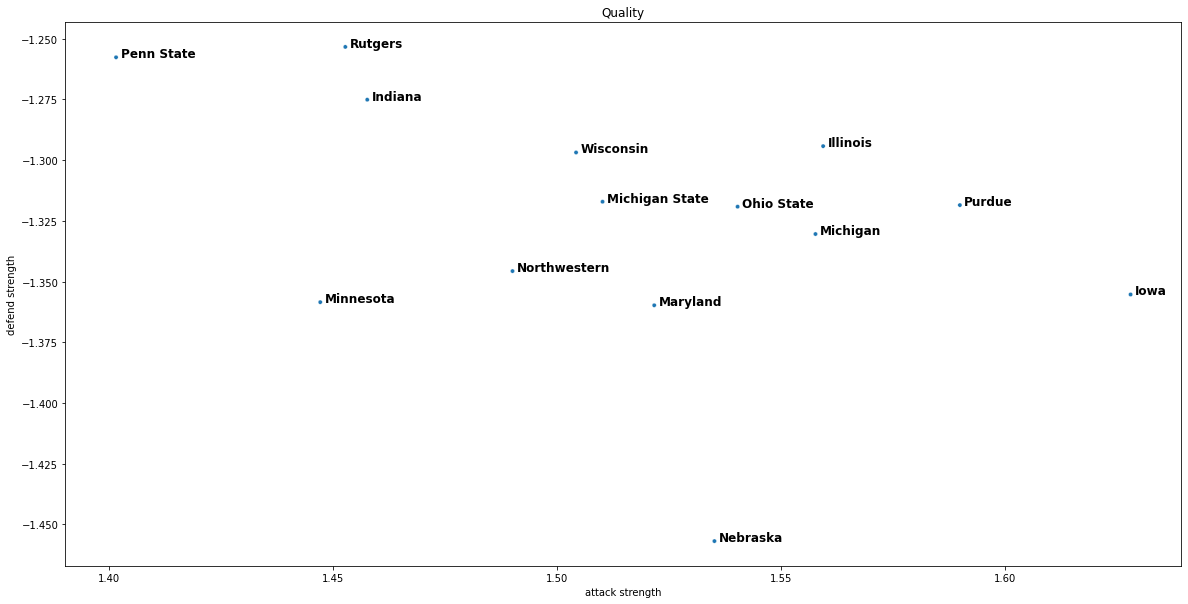

In [100]:

plt.figure(figsize=(20,10))
p1 = sns.scatterplot('attack', # Horizontal axis
       'defend', # Vertical axis
       data=qDF, # Data source
       size = 8,
       legend=False)  

for line in range(0,qDF.shape[0]):
     p1.text(qDF.attack[line]+0.001, qDF.defend[line], 
     qDF.Team[line], horizontalalignment='left', 
     size='large', color='black', weight='semibold')

plt.title('Quality')
# Set x-axis label
plt.xlabel('attack strength')
# Set y-axis label
plt.ylabel('defend strength')

In [101]:
teams

,Team,i
0,Ohio State,0
1,Illinois,1
2,Maryland,2
3,Penn State,3
4,Minnesota,4
5,Indiana,5
6,Wisconsin,6
7,Northwestern,7
8,Nebraska,8
9,Purdue,9


In [102]:
#now get the probability of Michigan State winning vs. Michigan
#it looks like I have to do a full set of teams
#just put in a full set of combinations
#generate an array with just each team once
predictive = Predictive(
    model=model, guide=guide, num_samples=30000, return_sites=["s1", "s2"]
)
msuMich = pd.DataFrame({'Home_id':[9,0,1,2,3,4,5,6,7,8,9,10,11,12,13],
        'Away_id':[7,0,1,2,3,4,5,6,7,8,9,10,11,12,13]})
predicted_score = predictive(
    home_id=msuMich["Home_id"].values,
    away_id=msuMich["Away_id"].values,
)


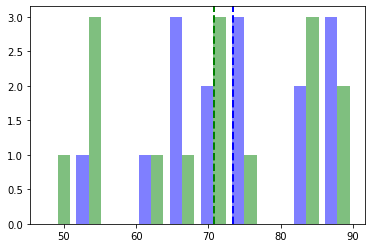

In [103]:
um = predicted_score["s1"][0].tolist()
msu = predicted_score["s2"][0].tolist()

def meanl(lst):
    return sum(lst) / len(lst)
plt.hist([um, msu], color=['b','g'], alpha=0.5)
plt.axvline(meanl(um), color='b', linestyle='dashed', linewidth=2)
plt.axvline(meanl(msu), color='g', linestyle='dashed', linewidth=2)


In [104]:
#work on the over under distribution
s1=um
s2=msu
n=100
sams1=rnd.choices(s1, k=n)
sams2=rnd.choices(s2, k=n)
overunder = [p1+p2 for p1 in sams1 for p2 in sams2]
spread    = [p1-p2 for p1 in sams1 for p2 in sams2]
samsDF = pd.DataFrame({'overunder':overunder,'spread':spread})


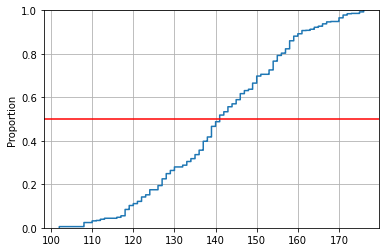

In [105]:
sns.ecdfplot(overunder)
plt.grid()
plt.axhline(y=0.5, color='r', linestyle='-')

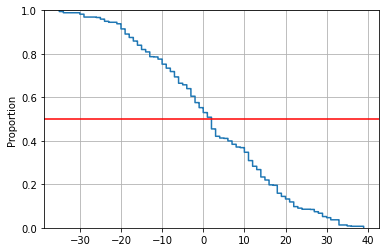

In [106]:
#probability of team1 wining by at least x points
sns.ecdfplot(spread,complementary=True)
plt.grid()
plt.axhline(y=0.5, color='r', linestyle='-')